In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [3]:
sns.set_context("talk")
sns.set_theme(style='white')
sns.set_style("darkgrid")
sns.set_palette('bright')

In [4]:
df_MAIN = pd.read_csv('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/MAIN_DF.csv')
df_MAIN.set_index("Unnamed: 0", inplace = True)
df_MAIN = df_MAIN.replace(np.nan, 0)

In [5]:
df_corpus = pd.read_csv(r'/home/crazyjeannot/Documents/doctorat/data/data_chapitres/metadata/corpus_metadata.csv')
df_corpus.set_index("doc_name", inplace = True)

In [6]:
#df_MAIN = df_MAIN.iloc[:,:1833]

In [7]:
def normalize_vectors_as_probabilities(df):
    # Get the columns containing the vectors (excluding the 'date' column)
    vector_columns = [col for col in df.columns if col != 'date']

    # Create the MinMaxScaler object
    scaler = MinMaxScaler()#MinMaxScaler, StandardScaler, Normalizer

    # Normalize each vector to represent a probability distribution
    for col in vector_columns:
        vector = df[col].values.reshape(-1, 1)
        normalized_vector = scaler.fit_transform(vector).flatten()
        df[col] = normalized_vector

    return df

In [8]:
df_MAIN_normalized = normalize_vectors_as_probabilities(df_MAIN)

In [9]:
def get_df_with_dates(df):
    df_res = df.copy()
    list_date = []
    for elem in df_res.index:
        list_date.append(int(elem.split('_')[0]))
    df_res['date'] = list_date

    return df_res

In [10]:
df_MAIN_dated = get_df_with_dates(df_MAIN_normalized)

In [11]:
def get_birth_date(df, df_corpus):
    df_res = df.copy()
    list_birth = []
    for elem in list(df_res.index):
        if elem in list(df_corpus.index):
            match = re.match('[0-9]{4}', str(df_corpus.loc[elem].naissance))
            if match is not None:
                list_birth.append(int(df_corpus.loc[elem].naissance))
            else:
                list_birth.append('')
        else:
            list_birth.append('')
    df_res['birth_date'] = list_birth

    return df_res

In [12]:
df_MAIN_birthdated = get_birth_date(df_MAIN_dated, df_corpus)

In [13]:
len(df_MAIN_birthdated)

2940

In [14]:
df_MAIN_birthdated = df_MAIN_birthdated[df_MAIN_birthdated["birth_date"]!='']

In [15]:
len(df_MAIN_birthdated)

2837

In [16]:
# TEXT VS TEXT VERSION
def calculate_entropy(df, window, first_date, last_date):
    NOVELTY, INFLUENCE, novels, dates = [], [], [], []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        
        current_date = row['date']
        
        if current_date-window < first_date or current_date+window > last_date:
            continue
        start_date = max(first_date, current_date - window)
        end_date = min(last_date, current_date + window)

        # Filter texts within the specified window
        novelty_texts = df[(df['date'] >= first_date) & (df['date'] <= start_date)].drop('date', axis=1)
        influence_texts = df[(df['date'] >= end_date) & (df['date'] <= last_date)].drop('date', axis=1)

        # Compute the entropy of the text
        text_novelty = entropy(row.drop('date').values, np.mean(novelty_texts.values, axis=0))
        text_influence = entropy(row.drop('date').values, np.mean(influence_texts.values, axis=0))

        NOVELTY.append(text_novelty)
        INFLUENCE.append(text_influence)
        novels.append(index)
        dates.append(current_date)
    return NOVELTY, INFLUENCE, novels, dates


In [ ]:
# Text scale
NOVELTY, INFLUENCE, novels, dates = calculate_entropy(df_MAIN_dated, 30, 1811, 2020)

In [18]:
def calculate_entropy_birthdate_cvc(df, window, first_date, last_date):
    NOVELTY, INFLUENCE, novels, dates, birth_dates = [], [], [], [], []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        
        
        current_date = row['date']
        current_birthdate = row['birth_date']
        
        if current_birthdate-(2*window) < first_date or current_birthdate+(2*window) > last_date:
            continue
            
        start_date_cohorts_before = max(first_date, current_birthdate - 2*window)
        end_date_cohorts_before = max(first_date, current_birthdate - window)
        
        start_date_cohorts_after = min(last_date, current_birthdate + window)
        end_date_cohorts_after = min(last_date, current_birthdate + 2*window)

        previous_cohort_texts = df[(df['birth_date'] >= start_date_cohorts_before) & (df['birth_date'] <= end_date_cohorts_before)].drop(['date', 'birth_date'], axis=1)
        next_cohort_texts = df[(df['birth_date'] >= start_date_cohorts_after) & (df['birth_date'] <= end_date_cohorts_after)].drop(['date', 'birth_date'], axis=1)
        
        text_novelty = entropy(row.drop(['date', 'birth_date']).values.astype(np.float64), np.mean(previous_cohort_texts.values, axis=0))
        text_influence = entropy(row.drop(['date', 'birth_date']).values.astype(np.float64), np.mean(next_cohort_texts.values, axis=0))

        NOVELTY.append(text_novelty)
        INFLUENCE.append(text_influence)
        novels.append(index)
        dates.append(current_date)
        birth_dates.append(current_birthdate)
    return NOVELTY, INFLUENCE, novels, dates, birth_dates


In [19]:
# COHORT VS COHORT VERSION
NOVELTY, INFLUENCE, novels, dates, birth_dates = calculate_entropy_birthdate_cvc(df_MAIN_birthdated, 30, 1751, 1992)

  0%|          | 0/2837 [00:00<?, ?it/s]

In [17]:
len(NOVELTY)

1930

In [18]:
len(df_MAIN_birthdated)

2837

In [20]:
def net_entropy(indexes, dates, entropies):
    net_index, net_dates, net_entropy = [], [], []
    i=0
    for index, date, entropy in zip(indexes, dates, entropies):
        if ~np.isinf(entropy):
            net_index.append(str(index))
            net_dates.append(int(date))
            net_entropy.append(float(entropy))
        else:
            i+=1
    print("faulty entropy values : ", i)
    return net_index, net_dates, net_entropy

In [21]:
net_novels_nov, net_dates_nov, net_NOVELTY = net_entropy(novels, birth_dates, NOVELTY)#birth_dates, dates

faulty entropy values :  31


In [22]:
data_nov = pd.DataFrame({'Index': net_novels_nov, 'Date': net_dates_nov, 'Mean_NOVELTY': net_NOVELTY})

In [23]:
net_novels_inf, net_dates_inf, net_INFLUENCE = net_entropy(novels, birth_dates, INFLUENCE)#birth_dates, dates

faulty entropy values :  9


In [24]:
data_inf = pd.DataFrame({'Index': net_novels_inf, 'Date': net_dates_inf, 'Mean_INFLUENCE': net_INFLUENCE})

### GET BEST NOVELS

In [27]:
data_nov[(data_nov['Mean_NOVELTY']>0.15) & (data_nov['Date']==1853)]

,Index,Date,Mean_NOVELTY


In [84]:
data_nov[(data_nov['Mean_NOVELTY']>0.15) & (data_nov['Date']==1873)]

,Index,Date,Mean_NOVELTY
329,1873_Daudet-Alphonse_Le-Cabecilla,1873,0.355585
330,1873_Daudet-Alphonse_Salvette-et-Bernadou,1873,0.342096
331,1873_Daudet-Alphonse_Wood-stown,1873,0.420074


In [93]:
data_nov[(data_nov['Mean_NOVELTY']>0.10) & (data_nov['Date']==1965)]

,Index,Date,Mean_NOVELTY
1829,1965_Delbo-Charlotte_Auschwitz-et-apres_I-Aucu...,1965,0.119188
1830,1965_Le-Clezio-Jean-Marie-Gustave_La-fievre,1965,0.502474
1831,1965_Perec-Georges_Les-choses,1965,0.116349
1834,1965_San-Antonio_Vas-y-Beru,1965,0.108622


In [86]:
data_nov[(data_nov['Mean_NOVELTY']>0.15) & (data_nov['Date']==1989)]

,Index,Date,Mean_NOVELTY
2041,1989_Celine-Louis-Ferdinand_Guignol-s-band,1989,0.188794
2045,1989_Perec-Georges_L-Infra-ordinaire,1989,0.220304
2046,1989_Simon-Claude_L-Acacia,1989,0.153861


In [92]:
data_nov[(data_nov['Mean_NOVELTY']>0.15) & (data_nov['Date']==1987)]

,Index,Date,Mean_NOVELTY
2033,1987_Simon-Claude_L-invitation,1987,0.172402


In [107]:
data_nov[(data_nov['Mean_NOVELTY']>0.15) & (data_nov['Date']==1976)]

,Index,Date,Mean_NOVELTY
1948,1976_Sarraute-Nathalie_disent-les-imbeciles,1976,0.161708


In [109]:
data_inf[(data_inf['Mean_INFLUENCE']<0.1) & (data_inf['Date']==1915)]

,Index,Date,Mean_INFLUENCE
1603,1915_Bourget-Paul_Le-sens-de-la-mort,1915,0.083712


In [110]:
data_inf[(data_inf['Mean_INFLUENCE']>0.2) & (data_inf['Date']==1853)]

,Index,Date,Mean_INFLUENCE
244,1853_Sand-George_La-fauvette-du-docteur,1853,0.369571


In [117]:
data_inf[(data_inf['Mean_INFLUENCE']>0.2) & (data_inf['Date']==1927)]

,Index,Date,Mean_INFLUENCE
1765,1927_Leblanc-Maurice_L-Homme-a-la-peau-de-bique,1927,0.219228


### BEST AUTHORS ?

In [138]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1814)]

,Index,Date,Mean_NOVELTY
22,1847_Achard-Amedee_Belle-Rose,1814,0.109163
194,1867_Houssaye-Arsene_La-Pantoufle-de-Cendrillo...,1814,0.181952
245,1871_Achard-Amedee_Recits-d-un-soldat,1814,0.133224
274,1873_Viollet-le-Duc-Eugene-Emmanuel_Histoire-d...,1814,0.117173
299,1875_Houssaye-Arsene_Les-Mille-et-une-nuits-pa...,1814,0.104048
409,1878_Houssaye-Arsene_Arsene-Houssaye-Les-Larme...,1814,0.115664
410,1878_Houssaye-Arsene_Les-Trois-duchesses_Tome-1,1814,0.101676


In [139]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1828)]

,Index,Date,Mean_NOVELTY
142,1863_Verne-Jules_Cinq-Semaines-en-ballon,1828,0.119047
171,1865_Verne-Jules_De-la-Terre-a-la-Lune,1828,0.104182
172,1865_ Verne-Jules_Les-Forceurs-de-blocus,1828,0.100189
243,1870_Verne-Jules_Vingt-mille-lieues-sous-les-mers,1828,0.148805
260,1872_Verne-Jules_Le-tour-du-monde-en-quatre-vi...,1828,0.106026
291,1874_Verne-Jules_Le-Chancellor,1828,0.111852
309,1875_Verne-Jules_L-Ile-Mysterieuse,1828,0.231755
355,1876_Verne-Jules_Michel-Strogoff,1828,0.113568
383,1877_Verne-Jules_Hector-Servadac-Voyages-et-av...,1828,0.168151
424,1878_Verne-Jules_Un-capitaine-de-quinze-ans,1828,0.131417


In [41]:
data_nov[(data_nov['Mean_NOVELTY']>0.3) & (data_nov['Date']==1840)]

,Index,Date,Mean_NOVELTY
251,1872_Daudet-Alphonse_Le-Bon-Dieu-de-Chemille-q...,1840,0.408914
252,1872_Daudet-Alphonse_Le-Pere-Achille,1840,0.379080
264,1873_Daudet-Alphonse_Le-Cabecilla,1840,0.357429
265,1873_Daudet-Alphonse_Salvette-et-Bernadou,1840,0.339790
266,1873_Daudet-Alphonse_Wood-stown,1840,0.420687


In [39]:
data_nov[(data_nov['Mean_NOVELTY']>0.2) & (data_nov['Date']==1850)]

,Index,Date,Mean_NOVELTY
879,1896_Loti-Pierre_La-mosquee-verte,1850,0.217154
937,1899_Loti-Pierre_La-chanson-des-vieux-epoux,1850,0.262106


In [142]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1862)]

,Index,Date,Mean_NOVELTY
129,1862_Villiers-de-l-Isle-Adam-Auguste_Isis,1862,0.103697
683,1887_Adam-Paul_La-glebe,1862,0.200726
700,1888_Barres-Maurice_Le-culte-du-moi_1-Sous-l-o...,1862,0.123382
725,1889_Barres-Maurice_Le-culte-du-moi_2-Un-homme...,1862,0.110582
768,1891_Barres-Maurice_Le-culte-du-moi_3-Le-jardi...,1862,0.104592
808,1893_Adam-Paul_Le-conte-futur,1862,0.205524
923,1899_Adam-Paul_La-Force,1862,0.118500
1107,1911_Barres-Maurice_Le-culte-du-moi_1-Sous-l'œ...,1862,0.116718


In [27]:
data_nov

,Index,Date,Mean_NOVELTY
0,1832_Vigny-Alfred-de_Stello,1832,0.084006
1,1835_Gautier-Theophile_Mademoiselle-de-Maupin,1811,0.087221
2,1838_Gautier-Theophile_Fortunio,1811,0.086586
3,1838_Wey-Francis_Les-enfants-du-marquis-de-Gan...,1812,0.067415
4,1840_Eyma-Xavier_Le-Medaillon,1816,0.068712
...,...,...,...
1894,2002_Calet-Henri_Poussieres-de-la-route,1904,0.075973
1895,2002_Tournier-Michel_Journal-Extime,1924,0.069849
1896,2008_Bauchau-Henry_Le-Boulevard-peripherique,1913,0.080444
1897,2010_Bauchau-Henry_Deluge,1913,0.104778


In [30]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1873)]

,Index,Date,Mean_NOVELTY
876,1896_Jarry-Alfred_L-Autre-Alceste,1873,0.303318
970,1902_Colette_Claudine-en-menage,1873,0.107566
983,1903_Colette_Claudine-s-en-va,1873,0.115842
1163,1916_Barbusse-Henri_Le-Feu,1873,0.118763
1201,1920_Colette_Cheri,1873,0.105889
1316,1927_Colette_Le-Ble-en-herbe,1873,0.102529


In [31]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1877)]

,Index,Date,Mean_NOVELTY
904,1897_Roussel-Raymond_La-doublure,1877,0.153972
957,1900_Roussel-Raymond_Chiquenaude,1877,0.273218
1102,1910_Roussel-Raymond_Impressions-d-Afrique,1877,0.145402
1159,1914_Roussel-Raymond_Locus-Solus,1877,0.118156


In [144]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1880)]

,Index,Date,Mean_NOVELTY
1106,1911_Apollinaire-Guillaume_Les-exploits-d-un-j...,1880,0.133513
1880,1993_Hemon-Louis_Ecrits-sur-le-Quebec,1880,0.120136


In [149]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1894)]

,Index,Date,Mean_NOVELTY
1429,1936_Celine-Louis-Ferdinand_Mort-a-credit,1894,0.114495
1639,1957_Celine-Louis-Ferdinand_D-un-chateau-L-autre,1894,0.142600
1874,1989_Celine-Louis-Ferdinand_Guignol-s-band,1894,0.185920


data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1900)]

In [37]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1869)]

,Index,Date,Mean_NOVELTY
856,1895_Gide-Andre_Paludes,1869,0.114899
890,1897_Gide-Andre_Les-nourritures-terrestres,1869,0.127453
1033,1906_Gide-Andre_Amyntas,1869,0.125752
1040,1907_Gide-Andre_Le-Retour-de-l-enfant-prodigue,1869,0.214158
1319,1927_Gide-Andre_Voyage-au-Congo,1869,0.106049
1424,1935_Gide-Andre_Les-nouvelles-nourritures,1869,0.129260


In [152]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1906)]

,Index,Date,Mean_NOVELTY
1543,1951_Beckett-Samuel_Molloy,1906,0.112872
1570,1953_Beckett-Samuel_L-Innommable,1906,0.168707
1771,1970_Beckett-Samuel_Le-Depeupleur,1906,0.206012
1879,1991_Boileau-Narcejac_La-main-passe,1906,0.104743


In [157]:
data_nov[(data_nov['Mean_NOVELTY']>0.1) & (data_nov['Date']==1918)]

,Index,Date,Mean_NOVELTY
1891,2000_Druon-Maurice_Les-Rois-Maudits,1918,0.15218


In [159]:
data_nov[(data_nov['Mean_NOVELTY']<0.07) & (data_nov['Date']==1925)]

,Index,Date,Mean_NOVELTY
1535,1950_Nimier-Roger_Le-Hussard-Bleu,1925,0.049563


In [172]:
data_inf

,Index,Date,Mean_INFLUENCE
0,1832_Vigny-Alfred-de_Stello,1832,0.084668
1,1835_Gautier-Theophile_Mademoiselle-de-Maupin,1811,0.071137
2,1838_Gautier-Theophile_Fortunio,1811,0.059144
3,1838_Wey-Francis_Les-enfants-du-marquis-de-Gan...,1812,0.057713
4,1840_Eyma-Xavier_Le-Medaillon,1816,0.063464
...,...,...,...
1916,2002_Calet-Henri_Poussieres-de-la-route,1904,0.072832
1917,2002_Tournier-Michel_Journal-Extime,1924,0.058534
1918,2008_Bauchau-Henry_Le-Boulevard-peripherique,1913,0.067506
1919,2010_Bauchau-Henry_Deluge,1913,0.090985


In [180]:
data_inf[(data_inf['Mean_INFLUENCE']<0.08) & (data_inf['Date']==1884)]

,Index,Date,Mean_INFLUENCE
631,1884_Badin-Adolphe_Couloirs-et-coulisses,1884,0.070859
1280,1923_Istrati-Panait_Les-recits-d-Adrien-Zograf...,1884,0.066048
1292,1924_Istrati-Panait_Les-recits-d-Adrien-Zograf...,1884,0.066437
1305,1925_Istrati-Panait_Les-recits-d-Adrien-Zograf...,1884,0.067271
1326,1926_Istrati-Panait_Les-recits-d-Adrien-Zograf...,1884,0.062421
1351,1928_Cami-Pierre-Henri_le-jugement-dernier,1884,0.057195
1420,1933_Duhamel-Georges_Le-notaire-du-Havre,1884,0.072937
1433,1934_Duhamel-Georges_Le-jardin-des-betes-sauvages,1884,0.068219
1434,1934_Duhamel-Georges_Vue-de-la-terre-promise,1884,0.063410
1448,1935_Duhamel-Georges_La-nuit-de-la-Saint-Jean,1884,0.060788


In [181]:
data_inf[(data_inf['Mean_INFLUENCE']>0.18)]

,Index,Date,Mean_INFLUENCE
273,1872_Daudet-Alphonse_Le-Bon-Dieu-de-Chemille-q...,1840,0.392034
274,1872_Daudet-Alphonse_Le-Pere-Achille,1840,0.359127
286,1873_Daudet-Alphonse_Le-Cabecilla,1840,0.350552
287,1873_Daudet-Alphonse_Salvette-et-Bernadou,1840,0.321771
288,1873_Daudet-Alphonse_Wood-stown,1840,0.410318
299,1874_Beaugrand-Honore_Anita-souvenirs-d-un-con...,1848,0.222419
331,1875_Verne-Jules_L-Ile-Mysterieuse,1828,0.242987
601,1883_David-Laurent-Olivier_Le-Heros-de-Chateau...,1883,0.204485
663,1885_Amero-Constant_Le-tour-de-France-d-un-pet...,1832,0.191899
684,1885_Verne-Jules_Mathias-Sandorf,1828,0.183548


### PLOT INFLUENCE / NOVELTY

In [25]:
merged_df = pd.merge(data_nov, data_inf, on='Index', how='inner')

In [26]:
good_df = merged_df[(merged_df['Mean_NOVELTY']<0.15) & (merged_df['Mean_INFLUENCE']<0.15)]# to modify to fit 0.8 text, 0.2 cvc, 

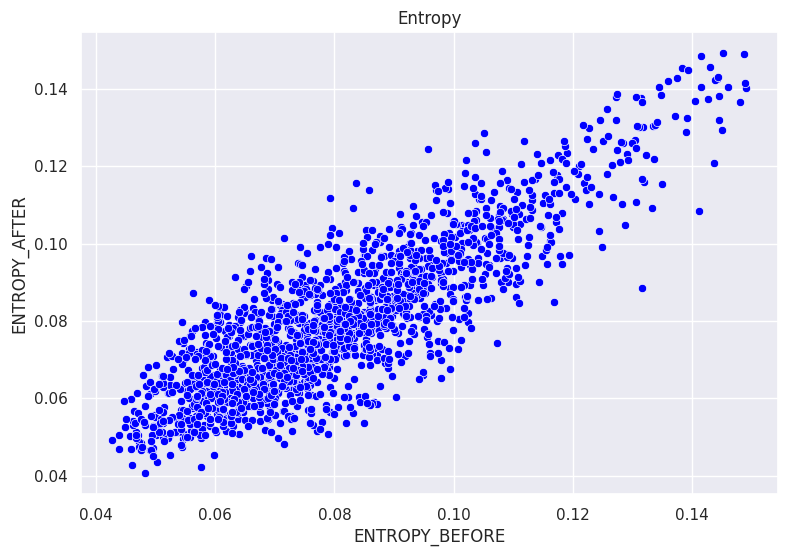

In [25]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Entropy')

ax = sns.scatterplot(data=good_df, x="Mean_NOVELTY", y="Mean_INFLUENCE", color='blue', ax=ax)

ax.set_xlabel('ENTROPY_BEFORE')
ax.set_ylabel('ENTROPY_AFTER')

plt.show()

In [29]:
df_corpus_canon = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/meta_data/df_canon_spec_last.csv')
df_corpus_canon.set_index(['doc_name'], inplace=True)

In [30]:
def get_df_with_canon(df, df_corpus):
    df_res = df.copy()
    list_subgenre = []
    for elem in list(df_res.index):
        if elem in list(df_corpus.index):
            list_subgenre.append(df_corpus.loc[elem].canon_auteur)#canon_auteur / canon_roman
        else:
            list_subgenre.append('')
    df_res['canon'] = list_subgenre

    return df_res

In [31]:
df_MAIN_canon = get_df_with_canon(good_df.set_index('Index'), df_corpus_canon)

In [32]:
df_MAIN_canon.canon.value_counts()

canon
non_canon    1249
canon         570
Name: count, dtype: int64

In [33]:
df_MAIN_canon_noncanon = df_MAIN_canon[df_MAIN_canon["canon"]=='non_canon']

In [34]:
df_MAIN_canon_canon = df_MAIN_canon[df_MAIN_canon["canon"]=='canon']

In [35]:
df_concat = pd.concat([df_MAIN_canon_noncanon, df_MAIN_canon_canon])

In [36]:
df_concat["index"]=df_concat.index

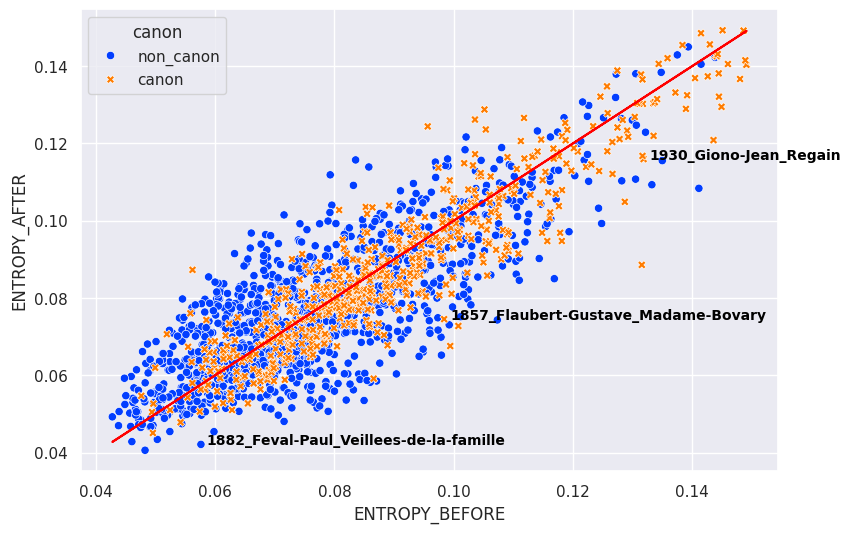

In [34]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
#ax.set_title('Entropy')

ax = sns.scatterplot(data=df_concat, x="Mean_NOVELTY", y="Mean_INFLUENCE", color='blue', style='canon', ax=ax, hue='canon', hue_order=['non_canon', 'canon'])

ax.set_xlabel('ENTROPY_BEFORE')
ax.set_ylabel('ENTROPY_AFTER')
plt.plot(df_concat['Mean_NOVELTY'], df_concat['Mean_NOVELTY'], color = 'red', label = 'x=y')

selected = ["1857_Flaubert-Gustave_Madame-Bovary", "1930_Giono-Jean_Regain", "1882_Feval-Paul_Veillees-de-la-famille"]
for line in range(0, df_concat.shape[0]):
    if df_concat["index"][line] in selected:
        plt.text(df_concat['Mean_NOVELTY'][line]+0.001, df_concat['Mean_INFLUENCE'][line], df_concat["index"][line], horizontalalignment='left', size='small', color='black', weight='semibold')

plt.savefig('ENTROPY_CANON_cvc_ANNOTATED_canon_auteur.png', format='png', bbox_inches='tight', dpi=400)

plt.show()

In [42]:
len(df_MAIN_canon_canon)

570

In [43]:
tst = df_MAIN_canon_canon[df_MAIN_canon_canon['Mean_NOVELTY']>df_MAIN_canon_canon['Mean_INFLUENCE']]
len(tst)

346

In [41]:
346/570

0.6070175438596491

In [44]:
len(df_MAIN_canon_noncanon)

1249

In [46]:
tst = df_MAIN_canon_noncanon[df_MAIN_canon_noncanon['Mean_NOVELTY']>df_MAIN_canon_noncanon['Mean_INFLUENCE']]
len(tst)

661

In [47]:
661/1249

0.5292233787029623

In [130]:
tst = df_concat[(df_concat['Mean_NOVELTY']>0.055) & (df_concat['Mean_INFLUENCE']<0.048) & (df_concat['canon']=='non_canon')]
tst

,Date_x,Mean_NOVELTY,Date_y,Mean_INFLUENCE,canon,index
Index,,,,,,
1878_Calonne-Alphonse-de_La-Ferme-des-moines,1818,0.059811,1818,0.045426,non_canon,1878_Calonne-Alphonse-de_La-Ferme-des-moines
1882_Feval-Paul_Veillees-de-la-famille,1816,0.057621,1816,0.042130,non_canon,1882_Feval-Paul_Veillees-de-la-famille


In [129]:
tst = df_concat[(df_concat['Mean_NOVELTY']>0.09) & (df_concat['Mean_INFLUENCE']<0.08) & (df_concat['canon']=='canon')]
tst

,Date_x,Mean_NOVELTY,Date_y,Mean_INFLUENCE,canon,index
Index,,,,,,
1857_Flaubert-Gustave_Madame-Bovary,1821,0.098399,1821,0.074533,canon,1857_Flaubert-Gustave_Madame-Bovary
1863_Gautier-Theophile_Le-capitaine-Fracasse,1811,0.100787,1811,0.072768,canon,1863_Gautier-Theophile_Le-capitaine-Fracasse


## PLOT PER YEAR

In [71]:
novelty_df[novelty_df['dates']==1828][20:25]

,index,dates,novelty
250,1871_Verne-Jules_Une-Ville-flottante,1828,0.096299
260,1872_Verne-Jules_Le-tour-du-monde-en-quatre-vi...,1828,0.106026
291,1874_Verne-Jules_Le-Chancellor,1828,0.111852
309,1875_Verne-Jules_L-Ile-Mysterieuse,1828,0.231755
355,1876_Verne-Jules_Michel-Strogoff,1828,0.113568


In [73]:
novelty_df[novelty_df['dates']==1844][20:25]

,index,dates,novelty
843,1894_France-Anatole_Le-Lys-rouge,1844,0.084967
851,1894_Tissot-Victor_Simone-Histoire-d-une-jeune...,1844,0.102763
855,1895_France-Anatole_Le-Puit-de-Sainte-Claire,1844,0.062349
877,1896_Laurie-Andre_La-Vie-de-college-dans-tous-...,1844,0.068530
888,1897_France-Anatole_L-orme-du-Mail,1844,0.059811


In [75]:
novelty_df[novelty_df['dates']==1855].head()

,index,dates,novelty
47,1855_Nerval-Gerard-de_Aurelia,1855,0.141462
484,1880_Letang-Louis_La-Belle-hotesse,1855,0.064946
803,1892_Rodenbach-Georges_Bruges-la-Morte,1855,0.108265
829,1893_Montegut-Maurice_Madame-Tout-le-monde,1855,0.071787
902,1897_Rodenbach-Georges_Le-Carillonneur,1855,0.094184


In [76]:
novelty_df[novelty_df['dates']==1870]

,index,dates,novelty
846,1894_Louÿs-Pierre_Les-chansons-de-Bilitis,1870,0.156336
864,1895_Louÿs-Pierre_Aphrodite--moeurs-antiques,1870,0.092772
918,1898_Louÿs-Pierre_La-femme-et-le-pantin,1870,0.083525
966,1901_Louÿs-Pierre_Les-aventures-du-roi-Pausole,1870,0.061320
1000,1904_Moselly-Emile_Jean-des-Brebis-ou-Le-livre...,1870,0.101083
1029,1906_Bordeaux-Henry_Les-Roquevillard,1870,0.082499
1043,1907_Moselly-Emile_Terres-lorraines,1870,0.122640
1108,1911_Chantepleure-Guy_La-passagere,1870,0.125115
1141,1913_Bordeaux-Henry_La-Maison,1870,0.091116


In [80]:
novelty_df[novelty_df['dates']==1875][50:]

,index,dates,novelty
1501,1947_Renard-Maurice_Le-Maitre-de-la-lumiere,1875,0.050666
1512,1948_Delly_La-jeune-fille-emmuree,1875,0.080308
1513,1948_Delly_La-rose-qui-tue,1875,0.068440
1520,1949_Delly_La-villa-des-serpents,1875,0.070540
1526,1950_Delly_Aurore-de-Brusfeld,1875,0.069342
1527,1950_Delly_Folie-de-sages,1875,0.072014
1528,1950_Delly_L'enfant-mysterieuse,1875,0.058303
1529,1950_Delly_Le-violon-du-tzigane,1875,0.064198
1530,1950_Delly_Les-seigneurs-loups,1875,0.068676
1531,1950_Delly_Rue-des-trois-graces,1875,0.077042


In [35]:
def get_df_to_plot(dates, entropy_values):
    # Calculate the mean entropy for each date
    unique_dates = np.unique(dates)
    mean_entropy = []

    for date in unique_dates:
        indices_for_date = np.where(dates == date)[0]
        if max(indices_for_date)<=len(entropy_values):
            entropy_for_date = np.array(entropy_values)[indices_for_date]
        
        if len(entropy_for_date) > 0:
            mean_entropy_for_date = np.mean(entropy_for_date)
        else:
            mean_entropy_for_date = np.nan
        
        mean_entropy.append(mean_entropy_for_date)
        
    # Create a DataFrame with dates and mean entropy values
    data = pd.DataFrame({'Date': unique_dates, 'Mean Entropy': mean_entropy})
    return data

In [36]:
novelty_df = pd.DataFrame(zip(net_novels_nov, net_dates_nov, net_NOVELTY), columns=["index", "dates", "novelty"])

In [37]:
novelty_canonized = get_df_with_canon(novelty_df.set_index('index'), df_corpus_canon)

In [38]:
novelty_non_canonized = novelty_canonized[novelty_canonized['canon']=='non_canon']
novelty_canonized = novelty_canonized[novelty_canonized['canon']=='canon']

In [39]:
df_novelty_canon_roman = get_df_to_plot(list(novelty_canonized.dates), list(novelty_canonized.novelty))

In [40]:
df_novelty_noncanon_roman= get_df_to_plot(list(novelty_non_canonized.dates), list(novelty_non_canonized.novelty))

In [41]:
df_novelty_canon_auteur = get_df_to_plot(list(novelty_canonized.dates), list(novelty_canonized.novelty))

In [42]:
df_novelty_noncanon_auteur= get_df_to_plot(list(novelty_non_canonized.dates), list(novelty_non_canonized.novelty))

In [ ]:
#df_novelty_noncanon_roman = df_novelty_noncanon_roman.drop(0)

In [141]:
influence_df = pd.DataFrame(zip(net_novels_nov, net_dates_nov, net_INFLUENCE), columns=["index", "dates", "influence"])

In [142]:
influence_canonized = get_df_with_canon(influence_df.set_index('index'), df_corpus_canon)

In [143]:
influence_non_canonized = influence_canonized[influence_canonized['canon']=='non_canon']
influence_canonized = influence_canonized[influence_canonized['canon']=='canon']

In [144]:
df_influence_canon_auteur = get_df_to_plot(list(influence_canonized.dates), list(influence_canonized.influence))

In [145]:
df_influence_noncanon_auteur= get_df_to_plot(list(influence_non_canonized.dates), list(influence_non_canonized.influence))

In [146]:
df_novelty = get_df_to_plot(net_dates_nov, net_NOVELTY)

In [147]:
df_influence = get_df_to_plot(net_dates_nov, net_INFLUENCE)

In [ ]:
#df_novelty = df_novelty.drop(0)

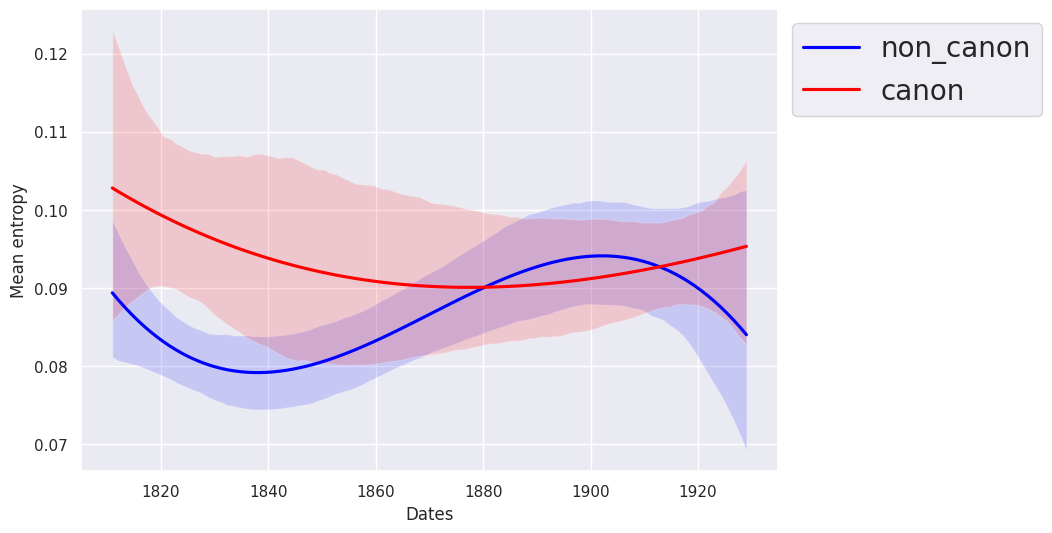

In [149]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
#ax.set_title('Mean novelty per birth year in our novels, broken out by canonicity tag')#of birth

ax = sns.regplot(data=df_novelty_noncanon_roman, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 order=3, 
                 scatter=False,
                 label="non_canon",
                 ax=ax)

ax = sns.regplot(data=df_novelty_canon_roman, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='red',
                 order=3, 
                 scatter=False,
                 label="canon",
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')


plt.legend()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = 20)

plt.savefig('ENTROPY_CANON_Roman.png', format='png', bbox_inches='tight', dpi=400)

plt.show()

In [67]:
test = df_novelty_canon_roman[df_novelty_canon_roman["Mean Entropy"]>0.12]

In [68]:
test

,Date,Mean Entropy
6,1828,0.129714
10,1844,0.130358
14,1855,0.124863
21,1870,0.122640
24,1875,0.163566


In [ ]:
1828, 1844, 1855, 1870, 1975

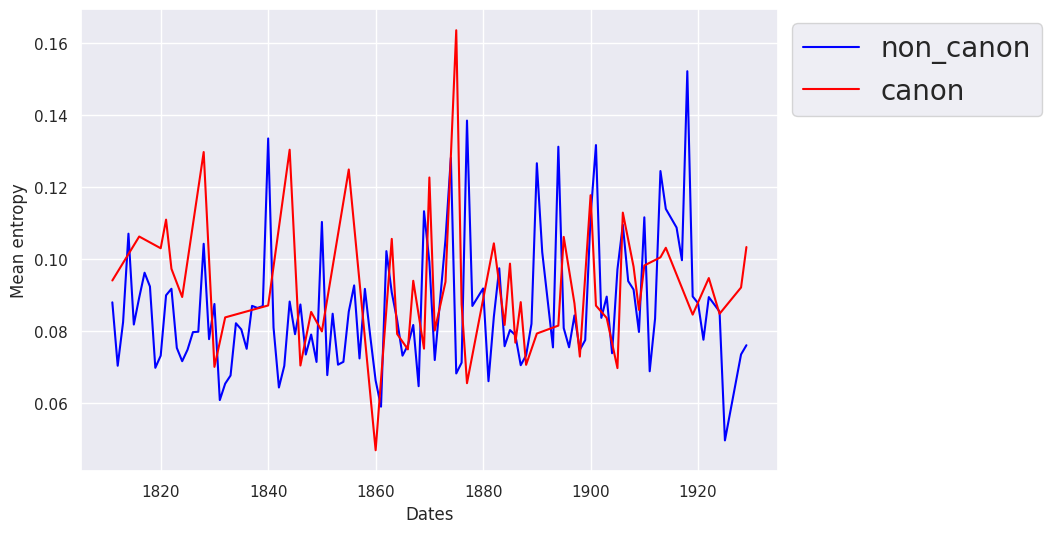

In [150]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax = sns.lineplot(data=df_novelty_noncanon_roman, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 label="non_canon",
                 ax=ax)

ax = sns.lineplot(data=df_novelty_canon_roman, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='red', 
                 label="canon",
                 ax=ax)


ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')


plt.legend()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = 20)
plt.savefig('ENTROPY_CANON_Roman_lined.png', format='png', bbox_inches='tight', dpi=400)

plt.show()


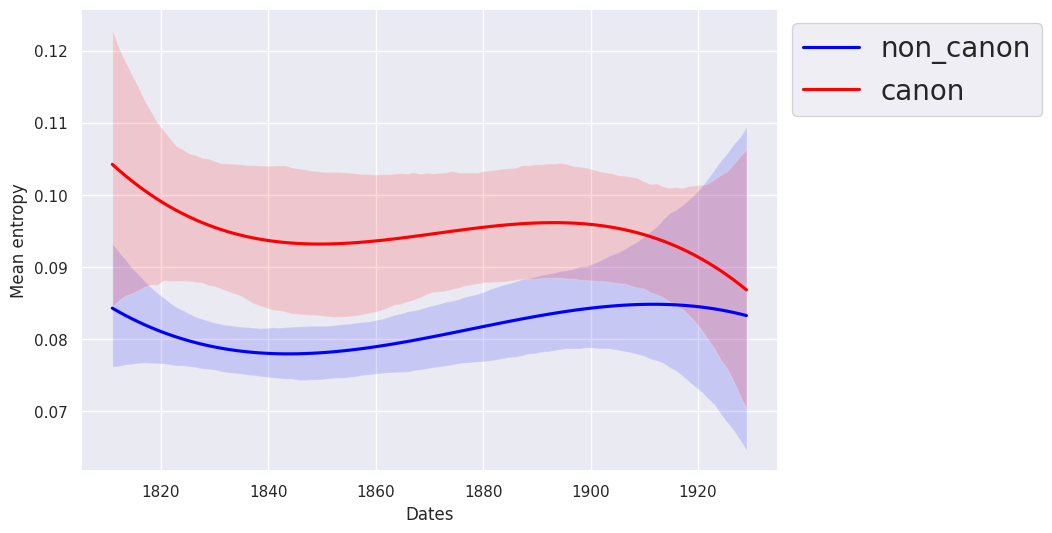

In [43]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
#ax.set_title('Variability between successive cohorts, broken out by canonicity tag')#of birth

ax = sns.regplot(data=df_novelty_noncanon_auteur, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 order=3, 
                 scatter=False,
                 label="non_canon",
                 ax=ax)

ax = sns.regplot(data=df_novelty_canon_auteur, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='red',
                 order=3, 
                 scatter=False,
                 label="canon",
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = 20)
plt.savefig('ENTROPY_CANON_Auteur.png', format='png', bbox_inches='tight', dpi=400)


plt.show()

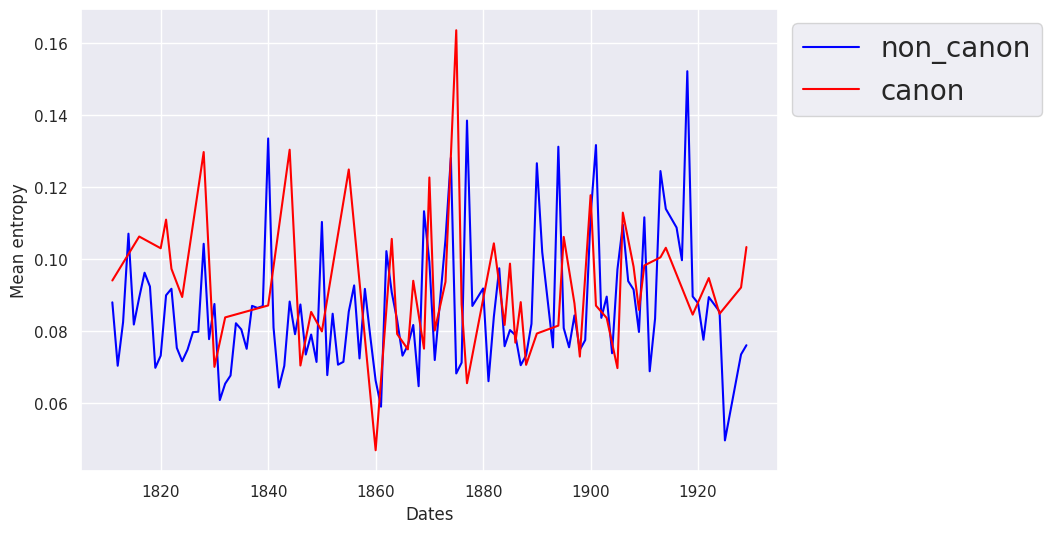

In [165]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax = sns.lineplot(data=df_novelty_noncanon_roman, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 label="non_canon",
                 ax=ax)

ax = sns.lineplot(data=df_novelty_canon_roman, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='red', 
                 label="canon",
                 ax=ax)


ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')


plt.legend()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = 20)
plt.savefig('ENTROPY_CANON_Auteur_lined.png', format='png', bbox_inches='tight', dpi=400)

plt.show()


In [42]:
test = df_novelty_noncanon_roman[df_novelty_noncanon_roman["Mean Entropy"]>0.13]

In [43]:
test

,Date,Mean Entropy
29,1872,0.141763
30,1873,0.159341
144,1987,0.134252
146,1989,0.132575
151,1995,0.142908
152,1997,0.152582
154,2000,0.152180


In [166]:
df_novelty

,Date,Mean Entropy
1,1812,0.070309
2,1813,0.082407
3,1814,0.107021
4,1815,0.081773
5,1816,0.089524
...,...,...
107,1922,0.090576
108,1924,0.085141
109,1925,0.049563
110,1928,0.077182


In [62]:
df_novelty[:100]

,Date,Mean Entropy
1,1812,0.070309
2,1813,0.082407
3,1814,0.107021
4,1815,0.081773
5,1816,0.089524
...,...,...
96,1910,0.108220
97,1911,0.068773
98,1912,0.083407
99,1913,0.115043


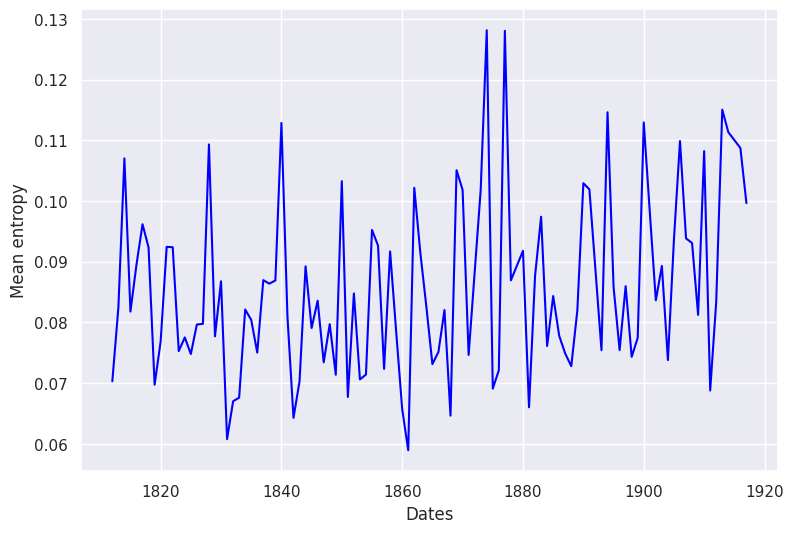

In [167]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
#ax.set_title('Mean novelty per year of birth in our novels')

ax = sns.lineplot(data=df_novelty[:102], 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.savefig('novelty_signal_cutted.png', format='png', bbox_inches='tight', dpi=400)

plt.show()

In [136]:
test = df_novelty[df_novelty["Mean Entropy"]<0.06]

In [137]:
test

,Date,Mean Entropy
50,1861,0.058933
109,1925,0.049563


In [135]:
test

,Date,Mean Entropy
3,1814,0.107021
17,1828,0.109313
29,1840,0.112858
39,1850,0.103259
51,1862,0.102169
58,1869,0.105073
59,1870,0.101823
61,1873,0.101849
62,1874,0.128125
65,1877,0.128028


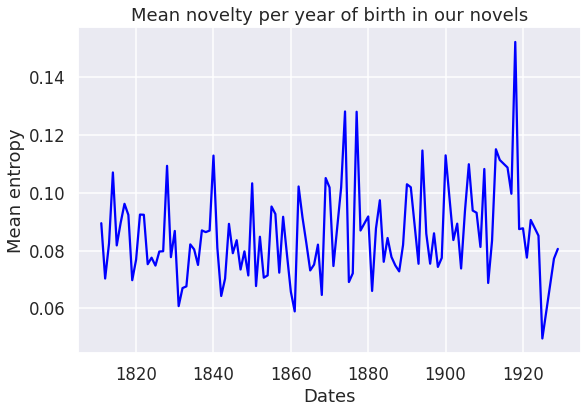

In [605]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean novelty per year of birth in our novels')

ax = sns.lineplot(data=df_novelty, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.show()

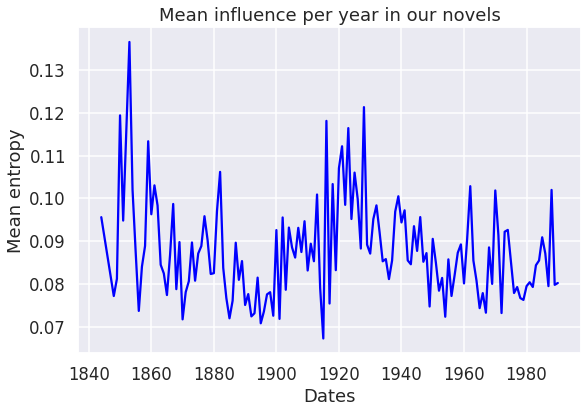

In [104]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean influence per year in our novels')

ax = sns.lineplot(data=df_influence, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.show()

In [98]:
test = df_influence[df_influence["Mean Entropy"]>0.12]

In [99]:
test

,Date,Mean Entropy
5,1853,0.136529
80,1928,0.121316


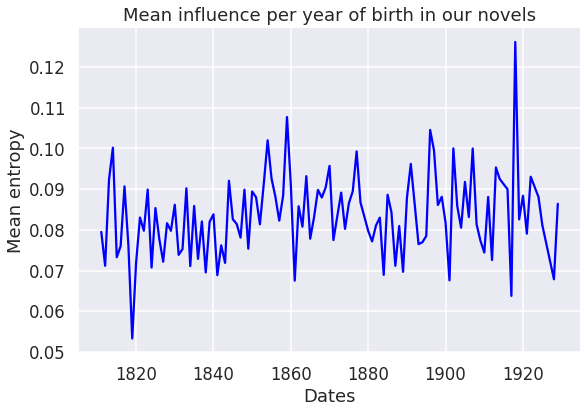

In [607]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean influence per year of birth in our novels')

ax = sns.lineplot(data=df_influence, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.show()

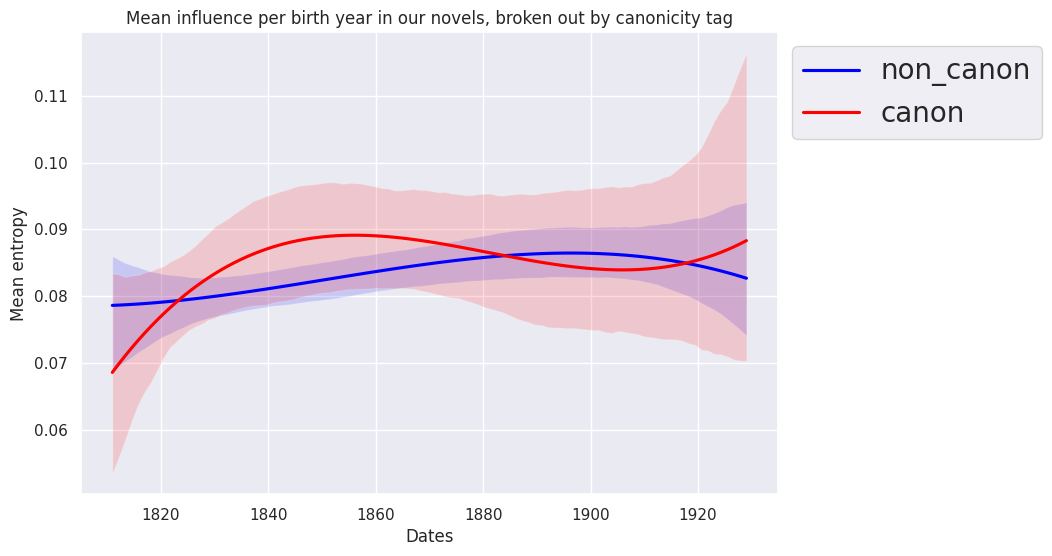

In [168]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean influence per birth year in our novels, broken out by canonicity tag')#of birth

ax = sns.regplot(data=df_influence_noncanon_auteur, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 order=3, 
                 scatter=False,
                 label="non_canon",
                 ax=ax)

ax = sns.regplot(data=df_influence_canon_auteur, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='red',
                 order=3, 
                 scatter=False,
                 label="canon",
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize = 20)
plt.savefig('INFLUENCE_CANON_Auteur.png', format='png', bbox_inches='tight', dpi=400)


plt.show()